Assignment 04: Networks

This project defines a spatial network using my personal movement data in Syracuse, exported from Google Takeout. Using commute destination points as nodes, I explore the differences between straight-line (Euclidean) distances and actual street-network distances between locations. I also reflect on how this affects urban experience and design.

Data source: commute_routes_syracuse_only.geojson


STEP 0: Prepare Environment: Import Libraries and Setup

In [4]:
!pip install osmnx


  Using cached osmnx-2.0.5-py3-none-any.whl.metadata (4.9 kB)
Using cached osmnx-2.0.5-py3-none-any.whl (101 kB)


In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
import osmnx as ox

STEP 1: Load My POI Points (This Time I do Syracuse, because it is where I life earlier, and the data are basically exported from the Google Takeout Commute Place)

<Axes: >

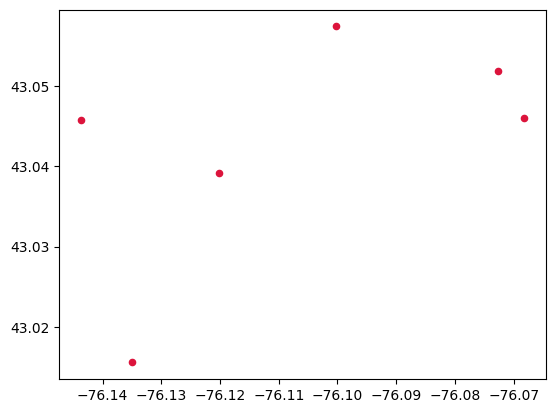

In [ ]:
nodes = gpd.read_file("commute_routes_syracuse_only.geojson")
nodes = nodes.to_crs(epsg=4326)  # WGS84
nodes.plot(markersize=20, color="crimson")

STEP 2: Get Syracuse Street Network

Get Walking Street network from OSM

In [ ]:
G = ox.graph_from_place("Syracuse, New York, USA", network_type="walk")

Convert to GeoDataFrame format for visualization

<Axes: >

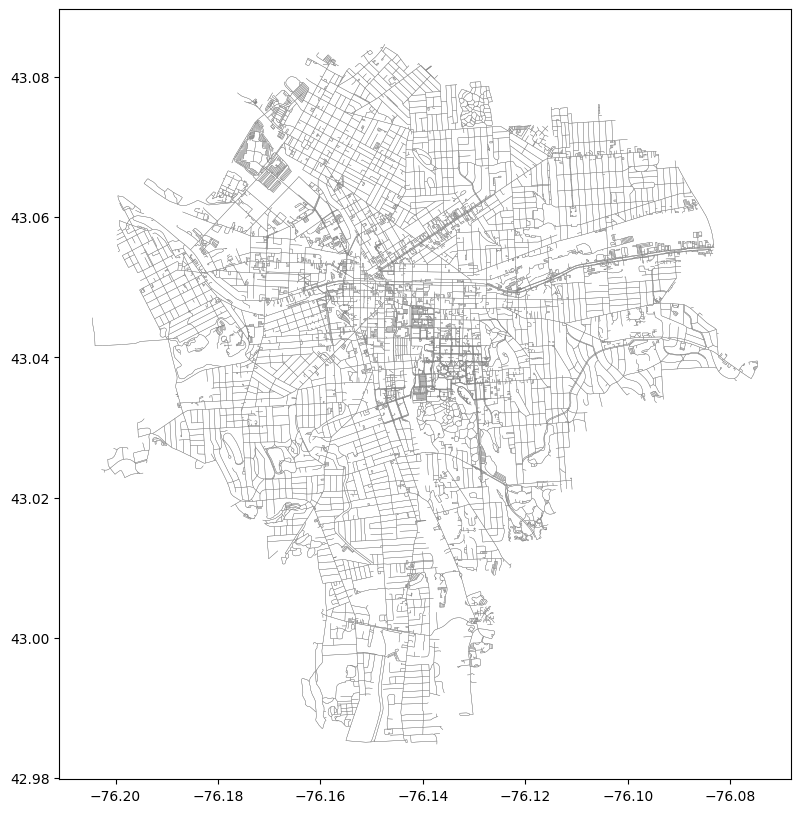

In [18]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges.plot(figsize=(10, 10), linewidth=0.25, color="gray")

STEP 3: Calculate Euclidean Distance Between Points

In [9]:
from itertools import combinations

# Calculate Euclidean distance between all pairs of points
euclidean_distances = []
for (i, a), (j, b) in combinations(nodes.iterrows(), 2):
    d = a.geometry.distance(b.geometry)
    euclidean_distances.append((a.geometry, b.geometry, d))

STEP 4: Calculate Network Distance (Street Distance)

Snap each point to its nearest node in the street network

In [10]:
# Function to snap point to street network
def snap_to_graph(point, G):
    return ox.distance.nearest_nodes(G, X=point.x, Y=point.y)


# Calculate network distances
network_distances = []
for (i, a), (j, b) in combinations(nodes.iterrows(), 2):
    try:
        a_node = snap_to_graph(a.geometry, G)
        b_node = snap_to_graph(b.geometry, G)
        length = nx.shortest_path_length(G, a_node, b_node, weight="length")
        network_distances.append((a.geometry, b.geometry, length))
    except nx.NetworkXNoPath:
        continue  # skip if no path found

STEP 5: Visualize the Differences

Trying to Plot both types of distances

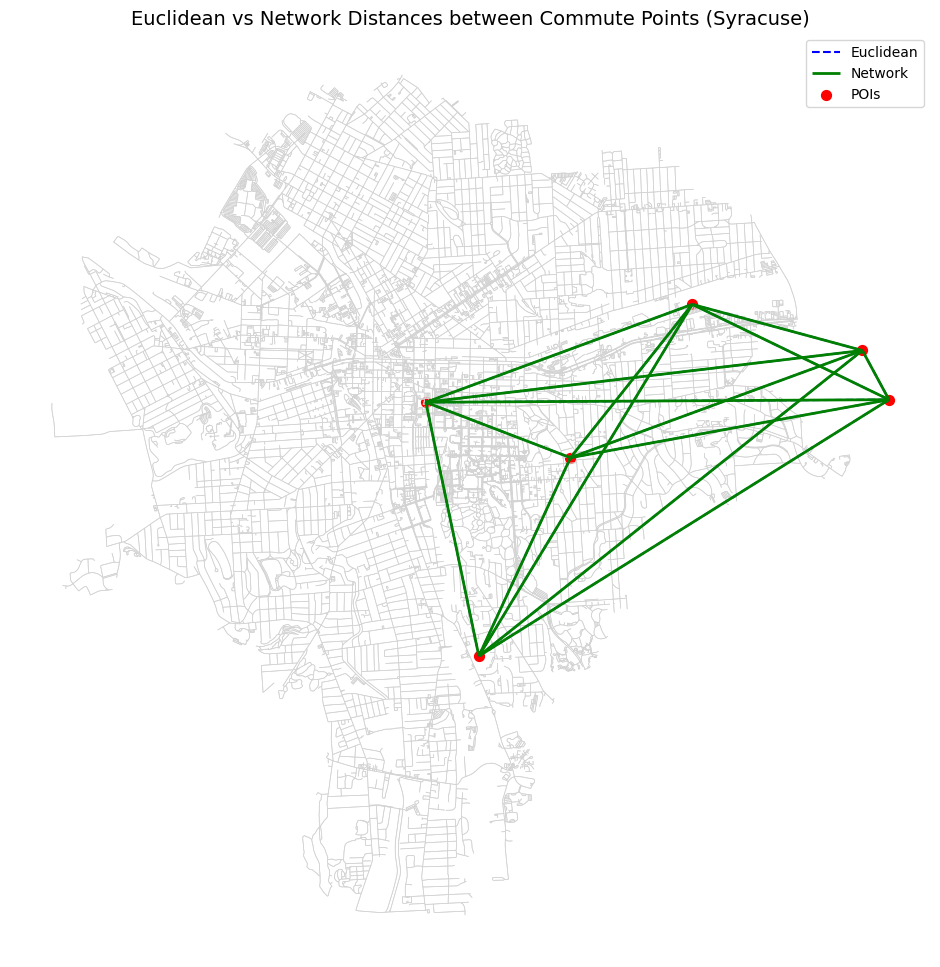

In [12]:
from shapely.geometry import LineString
import geopandas as gpd

# Build GeoDataFrames for Euclidean and network lines
euclidean_lines = [LineString([a, b]) for a, b, d in euclidean_distances]
network_lines = [LineString([a, b]) for a, b, d in network_distances]

euclidean_gdf = gpd.GeoDataFrame(geometry=euclidean_lines, crs="EPSG:4326")
network_gdf = gpd.GeoDataFrame(geometry=network_lines, crs="EPSG:4326")

# Plot all layers
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, color="lightgray", linewidth=0.5)
euclidean_gdf.plot(ax=ax, color="blue", linestyle="dashed", label="Euclidean")
network_gdf.plot(ax=ax, color="green", linewidth=2, label="Network")
nodes.plot(ax=ax, color="red", markersize=50, label="POIs")

ax.set_title(
    "Euclidean vs Network Distances between Commute Points (Syracuse)", fontsize=14
)
ax.legend()
ax.set_axis_off()
plt.show()

The result Seems not quite correct, since the Euclidean route and Street Network are overlapping, so next I need to work on revise it

STEP 6: Double Checking each map work seperately

And to begin with the Euclidean Map

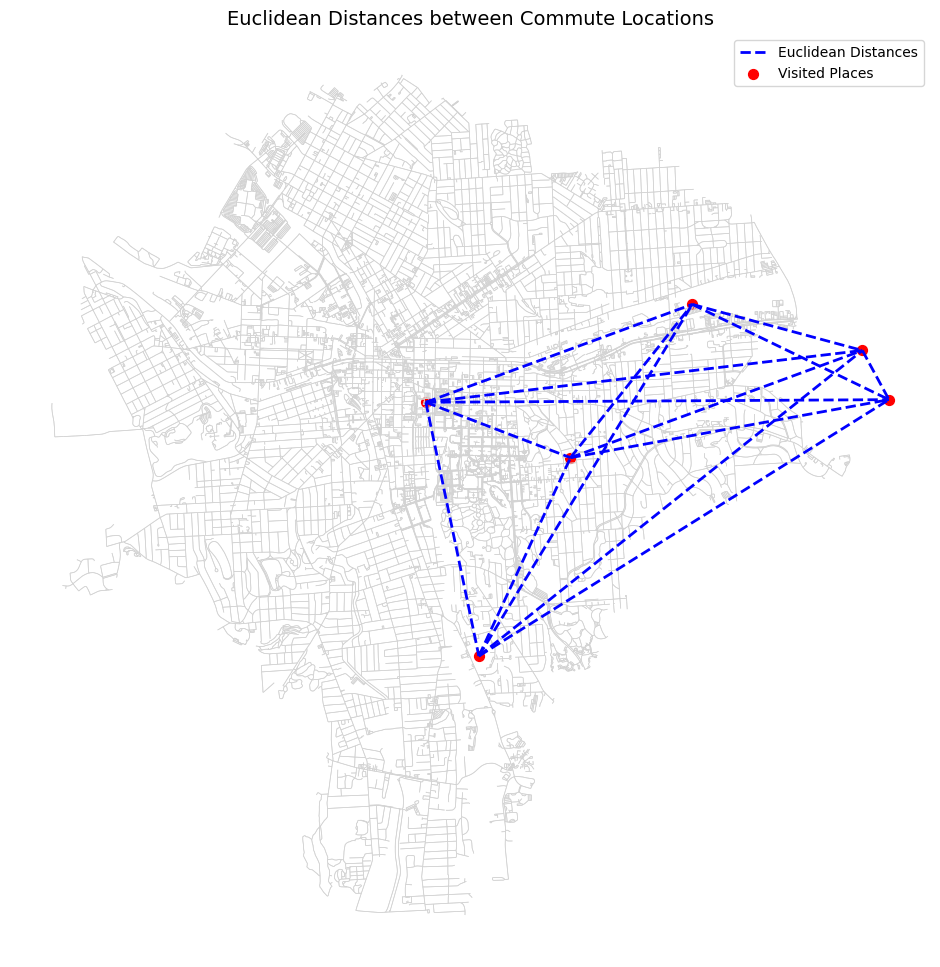

In [13]:
from shapely.geometry import LineString
import geopandas as gpd
import matplotlib.pyplot as plt

# Build a GeoDataFrame for Euclidean lines only
euclidean_lines = [LineString([a, b]) for a, b, d in euclidean_distances]
euclidean_gdf = gpd.GeoDataFrame(geometry=euclidean_lines, crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Optional: plot street network as background
edges.plot(ax=ax, color="lightgray", linewidth=0.5)

# Plot Euclidean lines
euclidean_gdf.plot(
    ax=ax, color="blue", linestyle="dashed", linewidth=2, label="Euclidean Distances"
)

# Plot nodes (visited places)
nodes.plot(ax=ax, color="red", markersize=50, label="Visited Places")

# Styling
ax.set_title("Euclidean Distances between Commute Locations", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.show()

Make Sense :-)

Then checking Network (Street) Distances Between Locations

In [14]:
network_distances = []  # already computed earlier

In [15]:
from shapely.geometry import LineString


# Function to build LineString path from list of nodes
def build_linestring_from_path(G, path):
    points = [Point((G.nodes[n]["x"], G.nodes[n]["y"])) for n in path]
    return LineString(points)


# Reconstruct LineStrings from network shortest paths
network_paths = []
for (i, a), (j, b) in combinations(nodes.iterrows(), 2):
    try:
        a_node = ox.distance.nearest_nodes(G, X=a.geometry.x, Y=a.geometry.y)
        b_node = ox.distance.nearest_nodes(G, X=b.geometry.x, Y=b.geometry.y)
        path = nx.shortest_path(G, a_node, b_node, weight="length")
        line = build_linestring_from_path(G, path)
        network_paths.append(line)
    except:
        continue  # skip if no path found

In [16]:
network_gdf = gpd.GeoDataFrame(geometry=network_paths, crs="EPSG:4326")

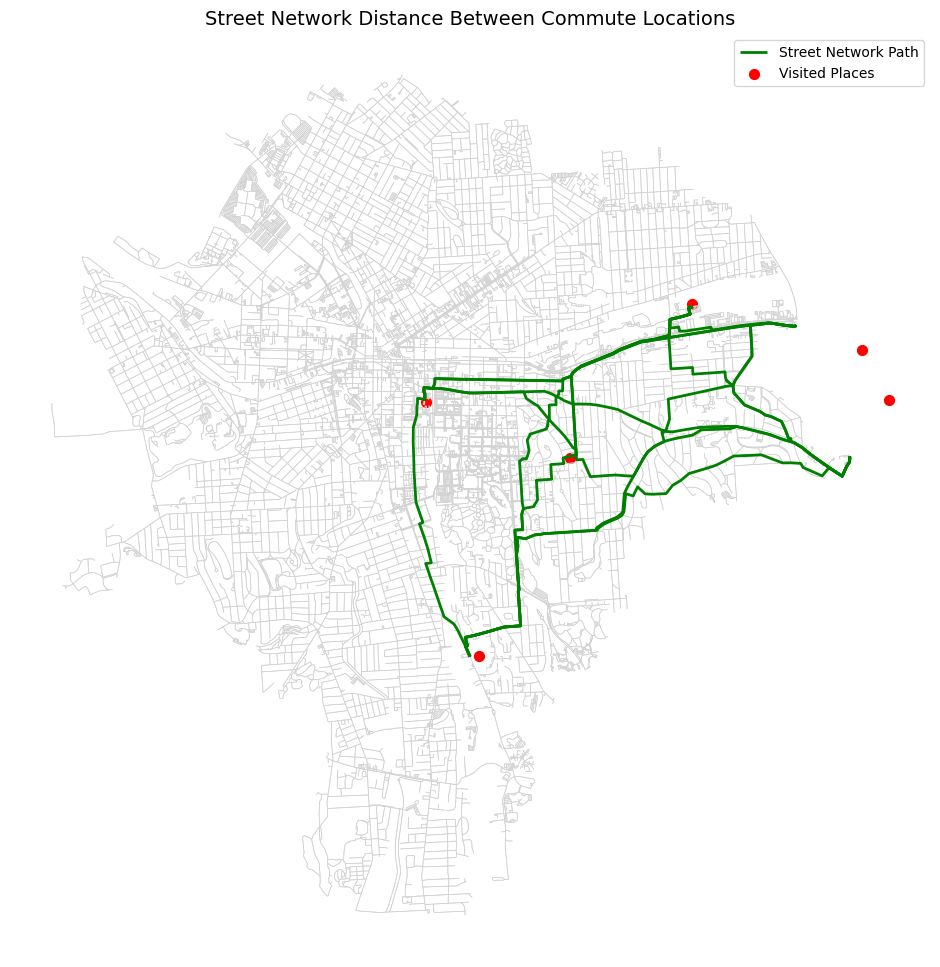

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

# Street background
edges.plot(ax=ax, color="lightgray", linewidth=0.5)

# Actual walking paths
network_gdf.plot(ax=ax, color="green", linewidth=2, label="Street Network Path")

# POI nodes
nodes.plot(ax=ax, color="red", markersize=50, label="Visited Places")

# Title and legend
ax.set_title("Street Network Distance Between Commute Locations", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.show()

Make way more sense then the original map
So will be ready to proceed to the next step

STEP 7: Comparing the Correct Street Network map with Euclidean Map

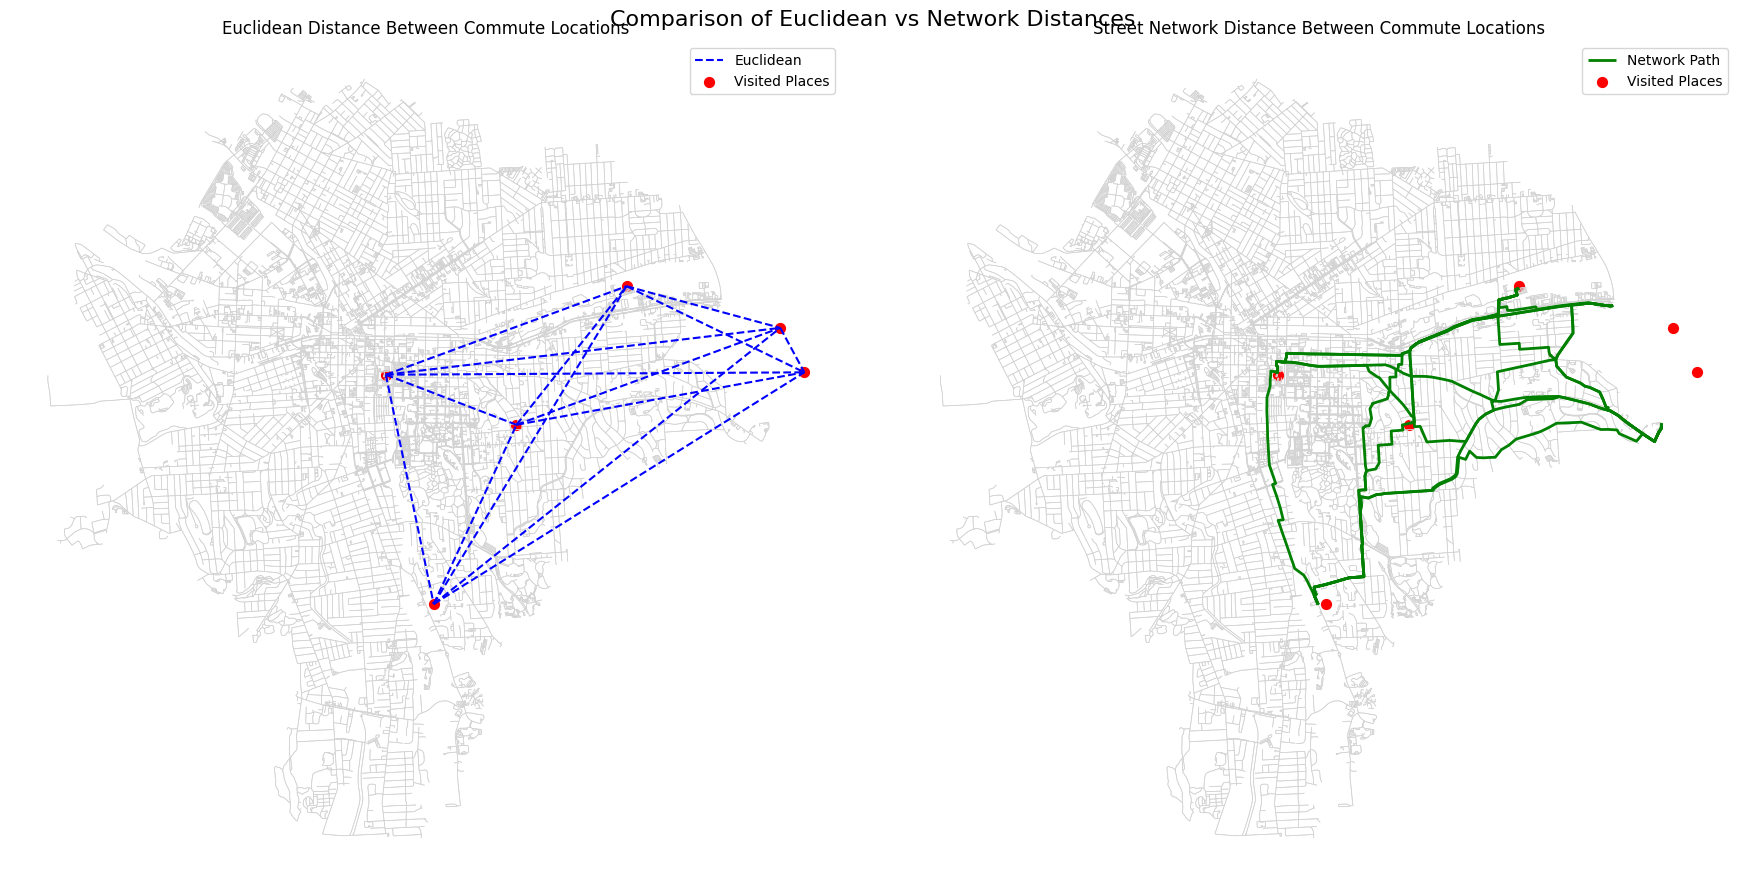

In [ ]:
import matplotlib.pyplot as plt

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), sharex=True, sharey=True)

# ----- LEFT: Euclidean distance map -----
edges.plot(ax=ax1, color="lightgray", linewidth=0.5)
euclidean_gdf.plot(
    ax=ax1, color="blue", linestyle="dashed", linewidth=1.5, label="Euclidean"
)
nodes.plot(ax=ax1, color="red", markersize=50, label="Visited Places")
ax1.set_title("Euclidean Distance Between Commute Locations")
ax1.axis("off")
ax1.legend()

# ----- RIGHT: Network distance map -----
edges.plot(ax=ax2, color="lightgray", linewidth=0.5)
network_gdf.plot(ax=ax2, color="green", linewidth=2, label="Network Path")
nodes.plot(ax=ax2, color="red", markersize=50, label="Visited Places")
ax2.set_title("Street Network Distance Between Commute Locations")
ax2.axis("off")
ax2.legend()

# Finalize
plt.suptitle("Comparison of Euclidean vs Network Distances", fontsize=16)
plt.tight_layout()
plt.show()

If I want to develop more, I want to calculate the average different commute times base on these two map
Maybe Could be my final project ?